# Image Classification with Tranfer Learning

### A Comparative Study of Transfer Learning Strategies for Produce Freshness Classification

**Class:** Advanced Machine Learning for Computer Vision

**Students:**
- Maxwell Bernard
- Johan Schommartz

## Import Libraries

In [ ]:
import random
import shutil
from collections import Counter
from pathlib import Path
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

## Download dataset

Set directory

In [ ]:
DATA_DIR = Path("/kaggle/input/fresh-and-stale-classification")

Load dataset from Kaggle and define paths

In [ ]:
# for kaggle
INPUT_DIR = Path("/kaggle/input/fresh-and-stale-classification/dataset")
WORKING_DIR = Path("/kaggle/working/dataset")

if not WORKING_DIR.exists():
    shutil.copytree(INPUT_DIR, WORKING_DIR)
    print("Copied dataset to working directory.")
else:
    print("Working directory already exists.")

DATA_DIR = WORKING_DIR
TRAIN_DIR = DATA_DIR / "Train"
TEST_DIR = DATA_DIR / "Test"


def list_class_folders(path: Path):
    print(f"\nClasses in: {path}")
    for folder in sorted(path.iterdir()):
        if folder.is_dir():
            print("-", folder.name)


list_class_folders(TRAIN_DIR)
list_class_folders(TEST_DIR)

Copied dataset to working directory.

Classes in: /kaggle/working/dataset/Train
- freshapples
- freshbanana
- freshbittergroud
- freshcapsicum
- freshcucumber
- freshokra
- freshoranges
- freshpotato
- freshtomato
- rottenapples
- rottenbanana
- rottenbittergroud
- rottencapsicum
- rottencucumber
- rottenokra
- rottenoranges
- rottenpotato
- rottentomato

Classes in: /kaggle/working/dataset/Test
- freshapples
- freshbanana
- freshcucumber
- freshokra
- freshoranges
- freshpatato
- freshtamto
- rottenapples
- rottenbanana
- rottencucumber
- rottenokra
- rottenoranges
- rottenpatato
- rottentamto


## Data Cleaning

 Fix class name typos

In [4]:
def rename_class(old_name: str, new_name: str):
    """Rename a classe in test directory to fix spelling errors ."""
    test_old_dir = TEST_DIR / old_name
    test_new_dir = TEST_DIR / new_name

    if test_old_dir.exists() and test_old_dir.is_dir():
        test_old_dir.rename(test_new_dir)
        print(f"Renamed {test_old_dir} to {test_new_dir}")


rename_class("rottentamto", "rottentomato")
rename_class("freshtamto", "freshtomato")
rename_class("rottenpatato", "rottenpotato")
rename_class("freshpatato", "freshpotato")

Renamed /kaggle/working/dataset/Test/rottentamto to /kaggle/working/dataset/Test/rottentomato
Renamed /kaggle/working/dataset/Test/freshtamto to /kaggle/working/dataset/Test/freshtomato
Renamed /kaggle/working/dataset/Test/rottenpatato to /kaggle/working/dataset/Test/rottenpotato
Renamed /kaggle/working/dataset/Test/freshpatato to /kaggle/working/dataset/Test/freshpotato


## Explorative Data Analysis

Count images per class and visualize class count


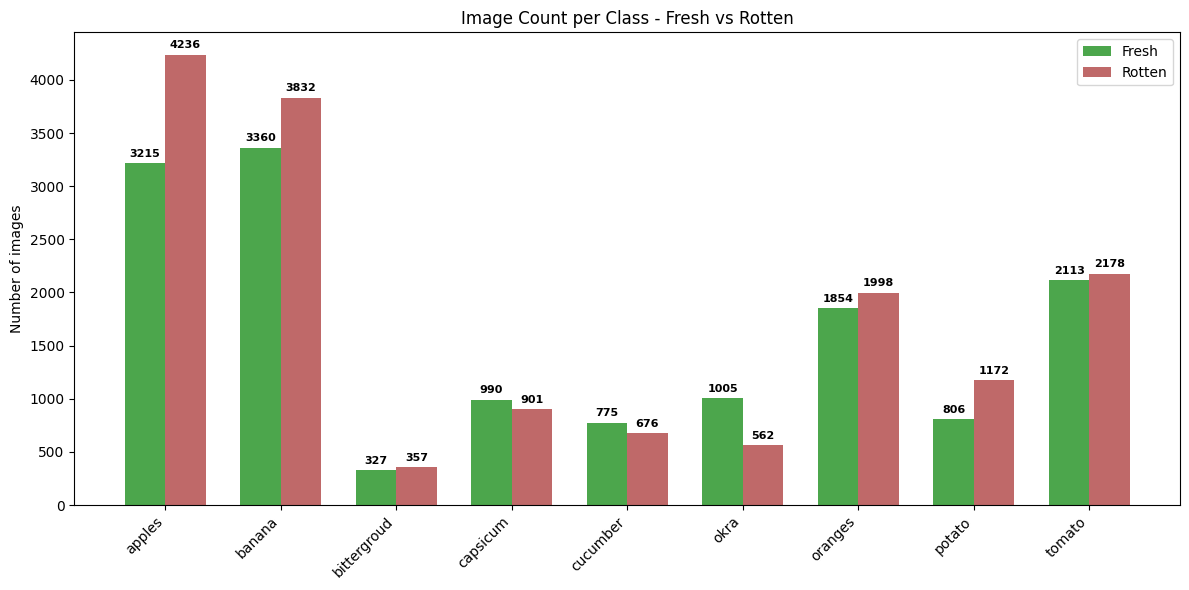

In [ ]:
def count_images(path: Path):
    counts = {}
    for cls in sorted(path.iterdir()):
        if cls.is_dir():
            n = len(list(cls.glob("*.jpg"))) + len(list(cls.glob("*.png")))
            counts[cls.name] = n
    return counts


train_counts = count_images(TRAIN_DIR)
test_counts = count_images(TEST_DIR)

combined_counts = {
    cls: train_counts.get(cls, 0) + test_counts.get(cls, 0)
    for cls in sorted(train_counts.keys() | test_counts.keys())
}


def plot_class_counts(combined_counts: dict):
    fresh_counts = {}
    rotten_counts = {}

    for class_name, count in combined_counts.items():
        if "fresh" in class_name.lower():
            base_name = (
                class_name.lower().replace("fresh", "").replace("rotten", "").strip()
            )
            fresh_counts[base_name] = count
        elif "rotten" in class_name.lower():
            base_name = (
                class_name.lower().replace("fresh", "").replace("rotten", "").strip()
            )
            rotten_counts[base_name] = count
        else:
            fresh_counts[class_name] = count
            rotten_counts[class_name] = 0

    all_classes = sorted(set(list(fresh_counts.keys()) + list(rotten_counts.keys())))

    fresh_values = [fresh_counts.get(cls, 0) for cls in all_classes]
    rotten_values = [rotten_counts.get(cls, 0) for cls in all_classes]

    plt.figure(figsize=(12, 6))

    bar_width = 0.35
    x_pos = np.arange(len(all_classes))

    fresh_bars = plt.bar(
        x_pos - bar_width / 2,
        fresh_values,
        bar_width,
        label="Fresh",
        color="green",
        alpha=0.7,
    )
    rotten_bars = plt.bar(
        x_pos + bar_width / 2,
        rotten_values,
        bar_width,
        label="Rotten",
        color="brown",
        alpha=0.7,
    )

    plt.xticks(x_pos, all_classes, rotation=45, ha="right")
    plt.title("Image Count per Class - Fresh vs Rotten")
    plt.ylabel("Number of images")
    plt.legend()

    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + max(fresh_values + rotten_values) * 0.01,
                    f"{int(height)}",
                    ha="center",
                    va="bottom",
                    fontsize=8,
                    fontweight="bold",
                )

    add_value_labels(fresh_bars)
    add_value_labels(rotten_bars)
    plt.tight_layout()
    plt.show()


plot_class_counts(combined_counts)

Count unique resolutions and display the most common sizes 

In [6]:
def iter_image_paths(root: Path):
    for class_dir in sorted(root.iterdir()):
        if class_dir.is_dir():
            for img_path in class_dir.glob("*"):
                if img_path.suffix.lower() in {".jpg", ".jpeg", ".png"}:
                    yield img_path


size_counter = Counter()

for img_path in list(iter_image_paths(TRAIN_DIR)) + list(iter_image_paths(TEST_DIR)):
    try:
        with Image.open(img_path) as img:
            size_counter[img.size] += 1
    except Exception as e:
        print(f"Failed to open {img_path}: {e}")

print(f"\nTotal unique sizes: {len(size_counter)}")

print("\nMost common image sizes (width, height):")
for (w, h), c in size_counter.most_common(10):
    print(f"{w} x {h}: {c} images")



Total unique sizes: 1458

Most common image sizes (width, height):
450 x 320: 5699 images
512 x 512: 4538 images
196 x 170: 739 images
200 x 200: 479 images
568 x 426: 421 images
390 x 396: 38 images
352 x 358: 38 images
400 x 338: 36 images
470 x 386: 34 images
518 x 332: 33 images


## Preprocessing

Remove bittergroud class from dataset due to insufficient number samples (n<500)

In [7]:
def remove_classes(class_names: list[str]):
    train_dirs = [d for d in TRAIN_DIR.iterdir() if d.is_dir()]
    test_dirs = [d for d in TEST_DIR.iterdir() if d.is_dir()]

    for train_dir in train_dirs:
        if any(
            class_name.lower() in train_dir.name.lower() for class_name in class_names
        ):
            shutil.rmtree(train_dir)
            print(f"Removed {train_dir}")

    for test_dir in test_dirs:
        if any(
            class_name.lower() in test_dir.name.lower() for class_name in class_names
        ):
            shutil.rmtree(test_dir)
            print(f"Removed {test_dir}")


remove_classes(["bittergroud"])

Removed /kaggle/working/dataset/Train/freshbittergroud
Removed /kaggle/working/dataset/Train/rottenbittergroud


Count number of images per file type

In [8]:
print("\nImage file types and their counts:")
file_type_counter = Counter()
for img_path in list(iter_image_paths(TRAIN_DIR)) + list(iter_image_paths(TEST_DIR)):
    file_type_counter[img_path.suffix.lower()] += 1
for file_type, count in file_type_counter.items():
    print(f"{file_type}: {count} images")


Image file types and their counts:
.png: 25819 images
.jpg: 3854 images


Converting all .png images into high quality .jpg images

In [9]:
def convert_png_to_high_quality_jpg(path: Path, quality=95):
    """Convert PNG to high-quality JPG to minimize quality loss"""
    from PIL import Image

    png_paths = list(path.rglob("*.png"))
    total_png = len(png_paths)

    print(f"Converting {total_png} PNG images to JPG")

    for i, png_path in enumerate(png_paths, 1):
        jpg_path = png_path.with_suffix(".jpg")
        img = Image.open(png_path).convert("RGB")
        img.save(jpg_path, "JPEG", quality=quality, optimize=True)
        png_path.unlink()

    remaining_png = len(list(path.rglob("*.png")))
    jpg_count = len(list(path.rglob("*.jpg")))

    print(f"Conversion complete in {path}:")
    print(f"  JPG images: {jpg_count}")
    print(f"  PNG images: {remaining_png}")


convert_png_to_high_quality_jpg(TRAIN_DIR)
convert_png_to_high_quality_jpg(TEST_DIR)

Converting 19081 PNG images to JPG
Conversion complete in /kaggle/working/dataset/Train:
  JPG images: 22935
  PNG images: 0
Converting 6738 PNG images to JPG
Conversion complete in /kaggle/working/dataset/Test:
  JPG images: 6738
  PNG images: 0


- Select only data from Kaggle training set for following steps
- Find the smallest class
- Downsample all classes to match it
- Split evenly into train/ validation / test data
- Create new balanced dataset

In [ ]:
OUT_ROOT = Path("data/fruit_balanced")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
SEED = 42
random.seed(SEED)

classes = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])

for split in ["train", "val", "test"]:
    for cls in classes:
        (OUT_ROOT / split / cls).mkdir(parents=True, exist_ok=True)


def collect_images(cls):
    cls_dir = TRAIN_DIR / cls
    imgs = list(cls_dir.glob("*.png")) + list(cls_dir.glob("*.jpg"))
    return imgs


per_class_counts = {cls: len(collect_images(cls)) for cls in classes}
min_count = min(per_class_counts.values())
print("Per-class counts:", per_class_counts)
print("Smallest class:", min_count)


TARGET_PER_CLASS = min_count

for cls in classes:
    all_imgs = collect_images(cls)
    random.shuffle(all_imgs)

    cls_target = min(TARGET_PER_CLASS, len(all_imgs))
    chosen = all_imgs[:cls_target]

    n_train = int(TRAIN_RATIO * cls_target)
    n_val = int(VAL_RATIO * cls_target)
    n_test = cls_target - n_train - n_val

    train_imgs = chosen[:n_train]
    val_imgs = chosen[n_train : n_train + n_val]
    test_imgs = chosen[n_train + n_val :]

    for src in train_imgs:
        shutil.copy2(src, OUT_ROOT / "train" / cls / src.name)
    for src in val_imgs:
        shutil.copy2(src, OUT_ROOT / "val" / cls / src.name)
    for src in test_imgs:
        shutil.copy2(src, OUT_ROOT / "test" / cls / src.name)

print(f"Balanced dataset created at {OUT_ROOT}")

for split in ["train", "val", "test"]:
    split_dir = OUT_ROOT / split
    total_imgs = 0
    for cls in classes:
        cls_dir = split_dir / cls
        total_imgs += len(list(cls_dir.glob("*.jpg")))
        total_imgs += len(list(cls_dir.glob("*.png")))
    print(f"{split.capitalize()} set: {total_imgs} images")

Per-class counts: {'freshapples': 2424, 'freshbanana': 2468, 'freshcapsicum': 990, 'freshcucumber': 496, 'freshokra': 635, 'freshoranges': 1466, 'freshpotato': 536, 'freshtomato': 1858, 'rottenapples': 3248, 'rottenbanana': 2932, 'rottencapsicum': 901, 'rottencucumber': 421, 'rottenokra': 338, 'rottenoranges': 1595, 'rottenpotato': 802, 'rottentomato': 1825}
Smallest class: 338
Balanced dataset created at data/fruit_balanced
Train set: 3776 images
Val set: 800 images
Test set: 832 images


Visualize training samples


Sample images from train set:


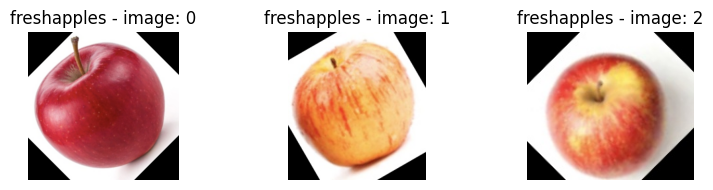

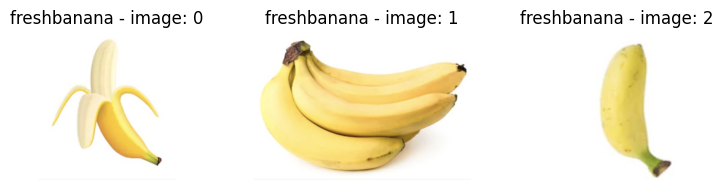

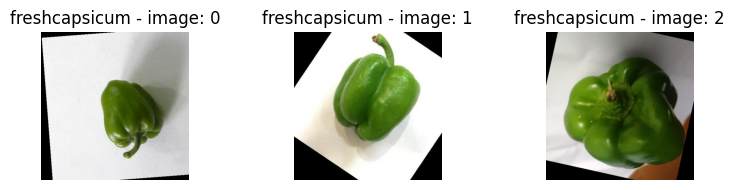

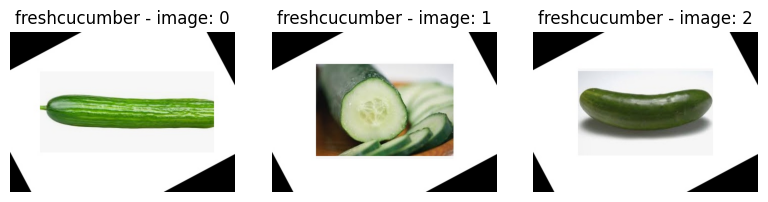

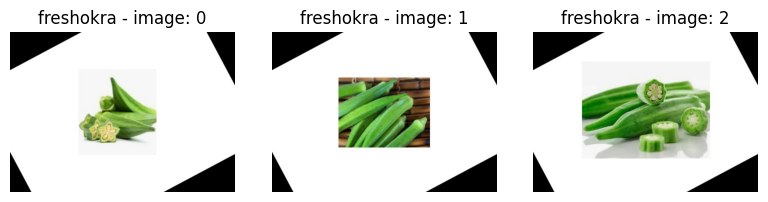

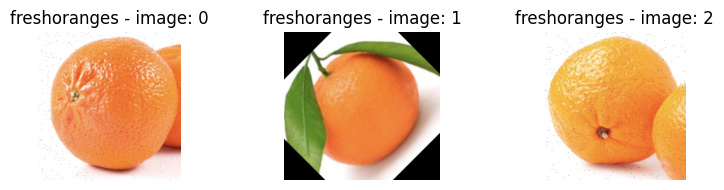

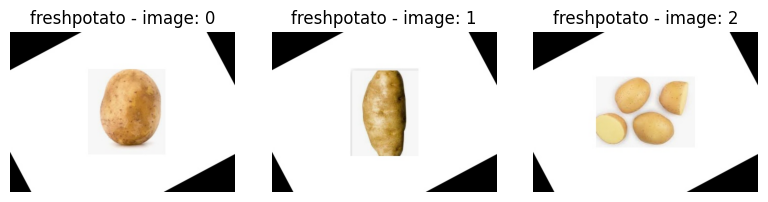

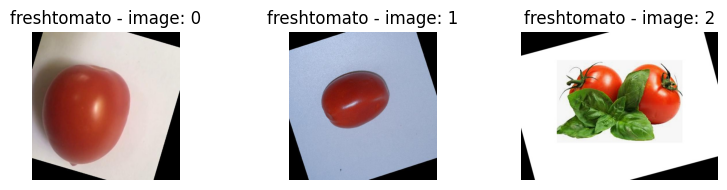

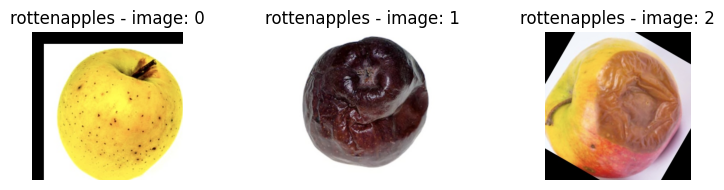

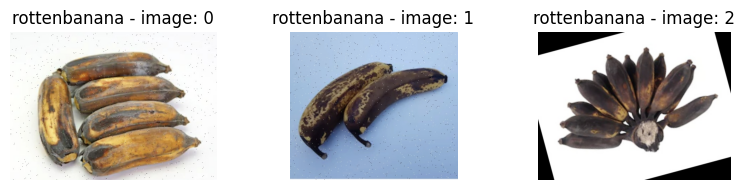

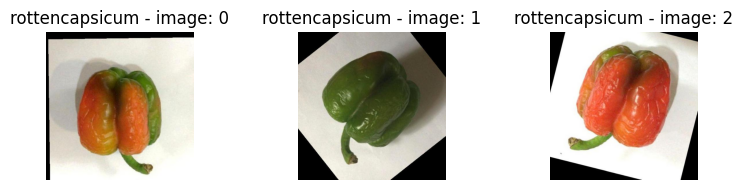

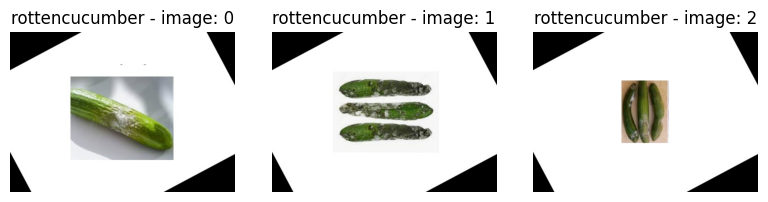

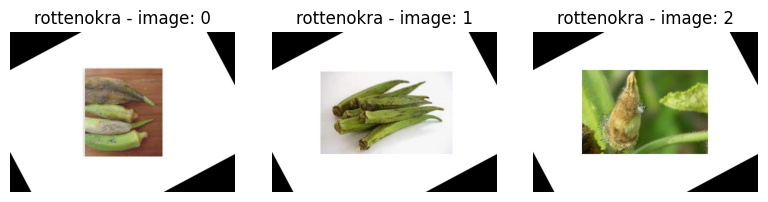

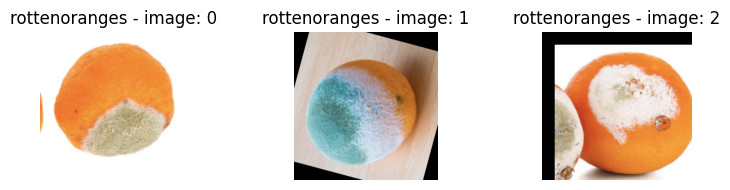

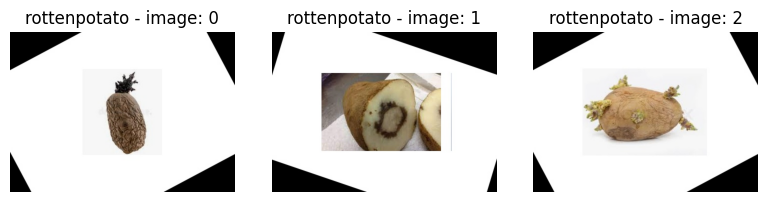

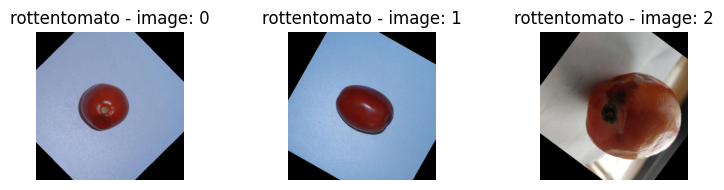

In [11]:
for split in ["train"]:
    print(f"\nSample images from {split} set:")
    for cls in classes:
        cls_dir = OUT_ROOT / split / cls
        random.seed(SEED)
        sample_imgs = random.sample(list(cls_dir.glob("*")), 3)
        plt.figure(figsize=(8, 2))
        for i, img_path in enumerate(sample_imgs):
            img = Image.open(img_path)
            plt.subplot(1, 3, i + 1)
            plt.imshow(img)
            plt.title(f"{cls} - {f'image: {i}'}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()

Verify balanced train/ validation/ test splits

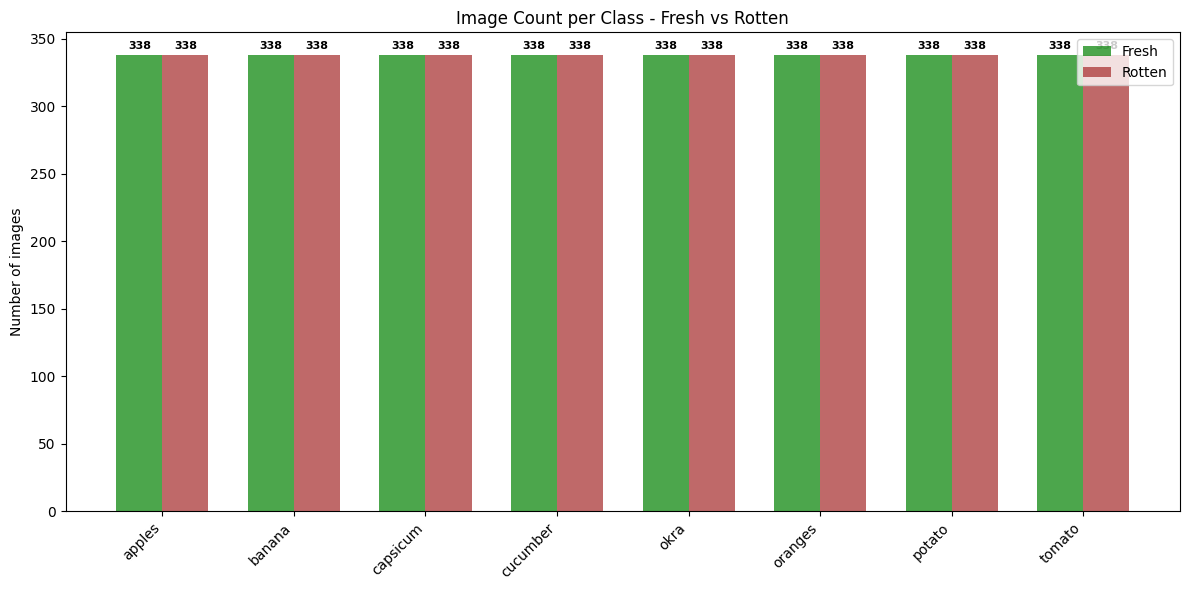

freshapples: Train=236, Val=50, Test=52, Total=338
freshbanana: Train=236, Val=50, Test=52, Total=338
freshcapsicum: Train=236, Val=50, Test=52, Total=338
freshcucumber: Train=236, Val=50, Test=52, Total=338
freshokra: Train=236, Val=50, Test=52, Total=338
freshoranges: Train=236, Val=50, Test=52, Total=338
freshpotato: Train=236, Val=50, Test=52, Total=338
freshtomato: Train=236, Val=50, Test=52, Total=338
rottenapples: Train=236, Val=50, Test=52, Total=338
rottenbanana: Train=236, Val=50, Test=52, Total=338
rottencapsicum: Train=236, Val=50, Test=52, Total=338
rottencucumber: Train=236, Val=50, Test=52, Total=338
rottenokra: Train=236, Val=50, Test=52, Total=338
rottenoranges: Train=236, Val=50, Test=52, Total=338
rottenpotato: Train=236, Val=50, Test=52, Total=338
rottentomato: Train=236, Val=50, Test=52, Total=338


In [12]:
TRAIN_DIR_BAL = OUT_ROOT / "train"
TEST_DIR_BAL = OUT_ROOT / "test"
VAL_DIR_BAL = OUT_ROOT / "val"

train_counts = count_images(TRAIN_DIR_BAL)
test_counts = count_images(TEST_DIR_BAL)
val_counts = count_images(VAL_DIR_BAL)

combined_counts_balanced = {
    cls: train_counts.get(cls, 0) + test_counts.get(cls, 0) + val_counts.get(cls, 0)
    for cls in sorted(train_counts.keys() | test_counts.keys() | val_counts.keys())
}
plot_class_counts(combined_counts_balanced)

for cls in classes:
    print(
        f"{cls}: Train={train_counts.get(cls, 0)}, Val={val_counts.get(cls, 0)}, Test={test_counts.get(cls, 0)}, Total={combined_counts_balanced.get(cls, 0)}"
    )


## Dataloaders with augmentations

- Define dataset and loader parameters (path, image size, batch size, workers)
- Set ImageNet normalization values
- Create training preprocessing pipeline, with:
    - "smart fridge"-like augmentation
    - resizing & random cropping images to 224×224
    - normalization with ImageNet norm. values
- Create train/ validation preprocessing pipeline, with:
    - resizing & center cropping images to 224×224
    - normalization with ImageNet norm. values
- Load train/val/test datasets using `ImageFolder`
    - Create DataLoaders for each split:
    - training loader → shuffled
    - validation loader → not shuffled
    - test loader → not shuffled


In [14]:
DATA_ROOT = Path("data/fruit_balanced")
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 4

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_tf = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(
            brightness=(0.5, 1.3),
            contrast=0.8,
            saturation=0.8,
            hue=0.03,
        ),
        transforms.RandomApply(
            [transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))],
            p=0.3,
        ),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

eval_tf = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(int(IMG_SIZE * 1.14)),
        transforms.CenterCrop(IMG_SIZE),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)


train_ds = datasets.ImageFolder(DATA_ROOT / "train", transform=train_tf)
val_ds = datasets.ImageFolder(DATA_ROOT / "val", transform=eval_tf)
test_ds = datasets.ImageFolder(DATA_ROOT / "test", transform=eval_tf)

class_names = train_ds.classes
num_classes = len(class_names)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

Visualize augmented samples

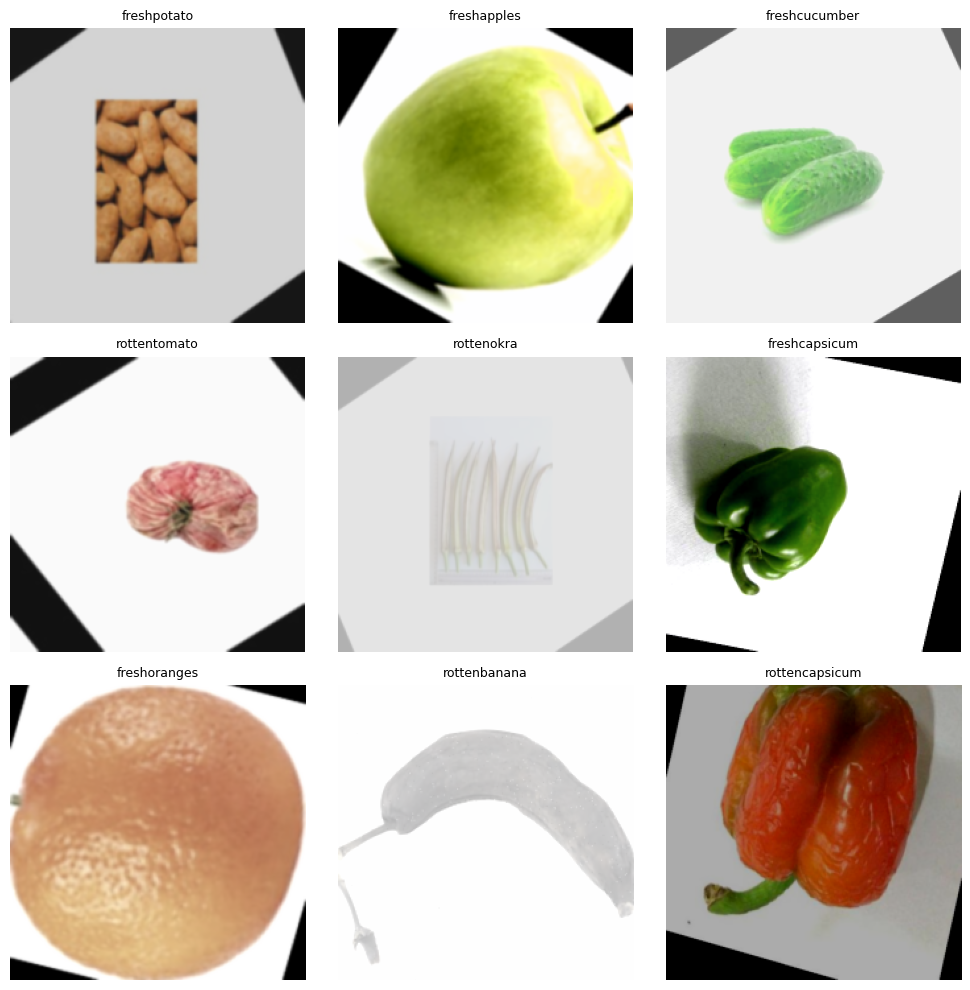

In [ ]:
def show_augmented_batch(dataset, n=9):
    """
    Display n augmented images from a dataset with transforms applied.
    """
    # Create a batch by sampling n items from the dataset
    idxs = torch.randint(0, len(dataset), (n,))

    images = []
    labels = []

    for idx in idxs:
        img, label = dataset[idx]  # transform already applied
        images.append(img)
        labels.append(dataset.classes[label])

    # Undo normalization for display
    mean = torch.tensor(IMAGENET_MEAN).reshape(3, 1, 1)
    std = torch.tensor(IMAGENET_STD).reshape(3, 1, 1)

    def denormalize(img):
        return img * std + mean

    # Plot grid
    rows = cols = int(np.sqrt(n))
    plt.figure(figsize=(10, 10))

    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.title(labels[i], fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


show_augmented_batch(train_ds)

## Training hardware & classes

Select device and read class names

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class_names = train_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)


Using device: cuda
Classes: ['freshapples', 'freshbanana', 'freshcapsicum', 'freshcucumber', 'freshokra', 'freshoranges', 'freshpotato', 'freshtomato', 'rottenapples', 'rottenbanana', 'rottencapsicum', 'rottencucumber', 'rottenokra', 'rottenoranges', 'rottenpotato', 'rottentomato']


## ViT-B/16 models

Define ViT-B/16 model creation function with three modes:
- pretrained and fully frozen
- pretrained and partially fine-tuneable
- fully trainable from scratch

In [17]:
def create_vit_b16(mode: str, num_classes: int):
    """
    mode:
      - 'pretrained_frozen'   : pretrained on ImageNet, only classifier trained
      - 'pretrained_finetune' : pretrained, last encoder block + classifier fine-tuned
      - 'scratch'             : same architecture, random init, trained from scratch
    """
    if mode in ["pretrained_frozen", "pretrained_finetune"]:
        weights = models.ViT_B_16_Weights.IMAGENET1K_V1
    else:
        weights = None

    model = models.vit_b_16(weights=weights)

    # replace classifier head to match num_classes
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, num_classes)

    # everything trainable
    for p in model.parameters():
        p.requires_grad = True

    if mode == "pretrained_frozen":
        # Freeze everything except the classifier head
        for p in model.encoder.parameters():
            p.requires_grad = False
        for p in model.conv_proj.parameters():
            p.requires_grad = False
        # model.heads stays trainable

    elif mode == "pretrained_finetune":
        # Freeze most layers
        for p in model.parameters():
            p.requires_grad = False

        # Unfreeze last encoder block + classifier
        for p in model.encoder.layers[-1].parameters():
            p.requires_grad = True

        for p in model.heads.parameters():
            p.requires_grad = True

    elif mode == "scratch":
        pass

    return model.to(device)

## ResNet-50 models

Define ResNet-50 model creation function with three modes:
- pretrained and fully frozen
- pretrained and partially fine-tuneable
- fully trainable from scratch

In [18]:
def create_resnet50(mode: str, num_classes: int):
    """
    Build a ResNet-50 model under the same three regimes as the ViT:
      - 'pretrained_frozen'
      - 'pretrained_finetune'
      - 'scratch'
    """

    # load weights
    if mode in ["pretrained_frozen", "pretrained_finetune"]:
        weights = models.ResNet50_Weights.IMAGENET1K_V2
    else:
        weights = None

    model = models.resnet50(weights=weights)

    # replace final classifier
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # Make everything trainable
    for p in model.parameters():
        p.requires_grad = True

    if mode == "pretrained_frozen":
        # freeze all convolutional layers
        for p in model.layer1.parameters():
            p.requires_grad = False
        for p in model.layer2.parameters():
            p.requires_grad = False
        for p in model.layer3.parameters():
            p.requires_grad = False
        for p in model.layer4.parameters():
            p.requires_grad = False

        # classifier head stays trainable
        for p in model.fc.parameters():
            p.requires_grad = True

    elif mode == "pretrained_finetune":
        # freeze early layers (layer1, layer2)
        for p in model.layer1.parameters():
            p.requires_grad = False
        for p in model.layer2.parameters():
            p.requires_grad = False

        # unfreeze deeper blocks (layer3, layer4) + classifier
        for p in model.layer3.parameters():
            p.requires_grad = True
        for p in model.layer4.parameters():
            p.requires_grad = True
        for p in model.fc.parameters():
            p.requires_grad = True

    return model.to(device)

## Training & evaluation functions

Two utility functions that define:
- how one full training epoch works
- how evaluation pass on validation/ test works

In [19]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


Defining the top-level training controller function

In [ ]:
def train_model(model, train_loader, val_loader, epochs, lr, weight_decay=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=lr,
        weight_decay=weight_decay,
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=2
    )

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion
        )
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        scheduler.step(val_loss)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch {epoch + 1}/{epochs} | "
            f"Train loss: {train_loss:.4f}, acc: {train_acc:.3f} | "
            f"Val loss: {val_loss:.4f}, acc: {val_acc:.3f}"
        )

    return model, history


Two utility functions that:
- run the model and collects predictions and true labels
- calculate loss/ accuracy with detailed performance reporting

In [21]:
def get_predictions_and_labels(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


def evaluate_on_test(model, test_loader, class_names):
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    y_true, y_pred = get_predictions_and_labels(model, test_loader)

    print(f"\nTest loss: {test_loss:.4f}, Test acc: {test_acc:.3f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    return test_loss, test_acc, cm


## Model training

Run the training of all three modes of both ViT-B/16 and ResNet-50

In [22]:
EXPERIMENTS = ["pretrained_frozen", "pretrained_finetune", "scratch"]

BACKBONES = {
    "vit_b16": create_vit_b16,
    "resnet50": create_resnet50,
}

results = {}

for backbone_name, create_fn in BACKBONES.items():
    results[backbone_name] = {}

    for mode in EXPERIMENTS:
        print(f"{backbone_name} | Experiment: {mode}")

        model = create_fn(mode, num_classes)

        if mode == "scratch":
            epochs = 15
            lr = 1e-3
        else:
            epochs = 10
            lr = 5e-4

        model, history = train_model(
            model,
            train_loader,
            val_loader,
            epochs=epochs,
            lr=lr,
            weight_decay=1e-4,
        )

        test_loss, test_acc, cm = evaluate_on_test(model, test_loader, class_names)

        results[backbone_name][mode] = {
            "model": model,
            "history": history,
            "test_loss": test_loss,
            "test_acc": test_acc,
            "confusion_matrix": cm,
        }

print("\nDone with all experiments for all backbones.")


vit_b16 | Experiment: pretrained_frozen


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 231MB/s] 


Epoch 1/10 | Train loss: 1.2735, acc: 0.679 | Val loss: 0.5863, acc: 0.844


Epoch 2/10 | Train loss: 0.5230, acc: 0.862 | Val loss: 0.3832, acc: 0.889


Epoch 3/10 | Train loss: 0.3850, acc: 0.896 | Val loss: 0.2978, acc: 0.916


Epoch 4/10 | Train loss: 0.3110, acc: 0.919 | Val loss: 0.2537, acc: 0.929


Epoch 5/10 | Train loss: 0.2665, acc: 0.930 | Val loss: 0.2186, acc: 0.931


Epoch 6/10 | Train loss: 0.2283, acc: 0.939 | Val loss: 0.1959, acc: 0.939


Epoch 7/10 | Train loss: 0.2042, acc: 0.948 | Val loss: 0.1868, acc: 0.940


Epoch 8/10 | Train loss: 0.1919, acc: 0.949 | Val loss: 0.1688, acc: 0.946


Epoch 9/10 | Train loss: 0.1744, acc: 0.951 | Val loss: 0.1621, acc: 0.950


Epoch 10/10 | Train loss: 0.1684, acc: 0.957 | Val loss: 0.1603, acc: 0.946



Test loss: 0.1830, Test acc: 0.942

Classification report:
                precision    recall  f1-score   support

   freshapples       0.91      0.96      0.93        52
   freshbanana       1.00      1.00      1.00        52
 freshcapsicum       1.00      1.00      1.00        52
 freshcucumber       0.85      0.98      0.91        52
     freshokra       0.85      0.98      0.91        52
  freshoranges       1.00      1.00      1.00        52
   freshpotato       0.94      0.96      0.95        52
   freshtomato       0.98      0.96      0.97        52
  rottenapples       0.90      0.90      0.90        52
  rottenbanana       1.00      1.00      1.00        52
rottencapsicum       1.00      1.00      1.00        52
rottencucumber       0.98      0.83      0.90        52
    rottenokra       0.95      0.73      0.83        52
 rottenoranges       0.98      0.90      0.94        52
  rottenpotato       0.83      0.92      0.87        52
  rottentomato       0.96      0.94      0.

Epoch 1/10 | Train loss: 0.4963, acc: 0.832 | Val loss: 0.1545, acc: 0.950


Epoch 2/10 | Train loss: 0.1767, acc: 0.938 | Val loss: 0.1569, acc: 0.950


Epoch 3/10 | Train loss: 0.1279, acc: 0.956 | Val loss: 0.1324, acc: 0.959


Epoch 4/10 | Train loss: 0.1040, acc: 0.966 | Val loss: 0.1551, acc: 0.949


Epoch 5/10 | Train loss: 0.0939, acc: 0.967 | Val loss: 0.1210, acc: 0.960


Epoch 6/10 | Train loss: 0.0783, acc: 0.971 | Val loss: 0.1339, acc: 0.956


Epoch 7/10 | Train loss: 0.0892, acc: 0.972 | Val loss: 0.1164, acc: 0.965


Epoch 8/10 | Train loss: 0.0788, acc: 0.974 | Val loss: 0.0936, acc: 0.971


Epoch 9/10 | Train loss: 0.0611, acc: 0.980 | Val loss: 0.1424, acc: 0.960


Epoch 10/10 | Train loss: 0.0512, acc: 0.983 | Val loss: 0.1095, acc: 0.969



Test loss: 0.1126, Test acc: 0.962

Classification report:
                precision    recall  f1-score   support

   freshapples       1.00      0.92      0.96        52
   freshbanana       1.00      1.00      1.00        52
 freshcapsicum       1.00      1.00      1.00        52
 freshcucumber       0.90      1.00      0.95        52
     freshokra       0.98      0.92      0.95        52
  freshoranges       1.00      1.00      1.00        52
   freshpotato       0.96      1.00      0.98        52
   freshtomato       1.00      0.98      0.99        52
  rottenapples       0.88      0.98      0.93        52
  rottenbanana       1.00      0.98      0.99        52
rottencapsicum       1.00      1.00      1.00        52
rottencucumber       1.00      0.83      0.91        52
    rottenokra       0.86      0.92      0.89        52
 rottenoranges       0.98      0.98      0.98        52
  rottenpotato       0.94      0.90      0.92        52
  rottentomato       0.93      0.96      0.

Epoch 1/15 | Train loss: 2.9712, acc: 0.076 | Val loss: 2.8762, acc: 0.084


Epoch 2/15 | Train loss: 2.8048, acc: 0.091 | Val loss: 2.6082, acc: 0.114


Epoch 3/15 | Train loss: 2.7091, acc: 0.109 | Val loss: 2.6713, acc: 0.095


Epoch 4/15 | Train loss: 2.7734, acc: 0.092 | Val loss: 2.6968, acc: 0.089


Epoch 5/15 | Train loss: 2.6443, acc: 0.108 | Val loss: 2.6615, acc: 0.089


Epoch 6/15 | Train loss: 2.5662, acc: 0.136 | Val loss: 2.4304, acc: 0.190


Epoch 7/15 | Train loss: 2.4950, acc: 0.145 | Val loss: 2.4635, acc: 0.166


Epoch 8/15 | Train loss: 2.4759, acc: 0.152 | Val loss: 2.6089, acc: 0.150


Epoch 9/15 | Train loss: 2.4277, acc: 0.168 | Val loss: 2.3916, acc: 0.201


Epoch 10/15 | Train loss: 2.3502, acc: 0.176 | Val loss: 2.1369, acc: 0.209


Epoch 11/15 | Train loss: 2.2941, acc: 0.187 | Val loss: 2.0818, acc: 0.280


Epoch 12/15 | Train loss: 2.2325, acc: 0.230 | Val loss: 2.1208, acc: 0.253


Epoch 13/15 | Train loss: 2.2444, acc: 0.215 | Val loss: 1.9527, acc: 0.294


Epoch 14/15 | Train loss: 2.1899, acc: 0.234 | Val loss: 1.9638, acc: 0.306


Epoch 15/15 | Train loss: 2.1326, acc: 0.245 | Val loss: 1.9478, acc: 0.289



Test loss: 1.9267, Test acc: 0.302

Classification report:
                precision    recall  f1-score   support

   freshapples       0.36      0.31      0.33        52
   freshbanana       0.40      0.87      0.55        52
 freshcapsicum       0.75      0.06      0.11        52
 freshcucumber       0.34      0.54      0.42        52
     freshokra       0.13      0.12      0.12        52
  freshoranges       0.50      0.21      0.30        52
   freshpotato       0.15      0.31      0.21        52
   freshtomato       0.54      0.52      0.53        52
  rottenapples       0.23      0.54      0.32        52
  rottenbanana       0.35      0.12      0.17        52
rottencapsicum       0.33      0.33      0.33        52
rottencucumber       0.37      0.13      0.20        52
    rottenokra       0.05      0.02      0.03        52
 rottenoranges       0.28      0.58      0.38        52
  rottenpotato       1.00      0.02      0.04        52
  rottentomato       0.33      0.17      0.

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 231MB/s]


Epoch 1/10 | Train loss: 1.9163, acc: 0.608 | Val loss: 1.3777, acc: 0.777


Epoch 2/10 | Train loss: 0.9884, acc: 0.820 | Val loss: 0.9128, acc: 0.823


Epoch 3/10 | Train loss: 0.7051, acc: 0.861 | Val loss: 0.6690, acc: 0.869


Epoch 4/10 | Train loss: 0.5654, acc: 0.869 | Val loss: 0.5157, acc: 0.896


Epoch 5/10 | Train loss: 0.4964, acc: 0.881 | Val loss: 0.4403, acc: 0.892


Epoch 6/10 | Train loss: 0.4448, acc: 0.892 | Val loss: 0.4471, acc: 0.891


Epoch 7/10 | Train loss: 0.4068, acc: 0.895 | Val loss: 0.4582, acc: 0.884


Epoch 8/10 | Train loss: 0.3596, acc: 0.907 | Val loss: 0.4037, acc: 0.910


Epoch 9/10 | Train loss: 0.3428, acc: 0.907 | Val loss: 0.4266, acc: 0.890


Epoch 10/10 | Train loss: 0.3175, acc: 0.917 | Val loss: 0.3129, acc: 0.921



Test loss: 0.3463, Test acc: 0.906

Classification report:
                precision    recall  f1-score   support

   freshapples       0.92      0.90      0.91        52
   freshbanana       1.00      1.00      1.00        52
 freshcapsicum       0.96      1.00      0.98        52
 freshcucumber       0.83      0.92      0.87        52
     freshokra       0.86      0.94      0.90        52
  freshoranges       0.88      0.98      0.93        52
   freshpotato       0.94      0.94      0.94        52
   freshtomato       0.94      0.94      0.94        52
  rottenapples       0.88      0.87      0.87        52
  rottenbanana       0.87      1.00      0.93        52
rottencapsicum       1.00      0.96      0.98        52
rottencucumber       0.81      0.67      0.74        52
    rottenokra       0.94      0.65      0.77        52
 rottenoranges       0.90      0.90      0.90        52
  rottenpotato       0.84      0.90      0.87        52
  rottentomato       0.94      0.90      0.

Epoch 1/10 | Train loss: 0.6687, acc: 0.793 | Val loss: 0.4181, acc: 0.874


Epoch 2/10 | Train loss: 0.2322, acc: 0.922 | Val loss: 0.2006, acc: 0.925


Epoch 3/10 | Train loss: 0.1771, acc: 0.937 | Val loss: 0.2483, acc: 0.920


Epoch 4/10 | Train loss: 0.1429, acc: 0.953 | Val loss: 0.1723, acc: 0.939


Epoch 5/10 | Train loss: 0.1134, acc: 0.964 | Val loss: 0.1562, acc: 0.951


Epoch 6/10 | Train loss: 0.0900, acc: 0.969 | Val loss: 0.1201, acc: 0.954


Epoch 7/10 | Train loss: 0.0938, acc: 0.967 | Val loss: 0.2177, acc: 0.946


Epoch 8/10 | Train loss: 0.0829, acc: 0.974 | Val loss: 0.1430, acc: 0.953


Epoch 9/10 | Train loss: 0.0923, acc: 0.969 | Val loss: 0.1278, acc: 0.960


Epoch 10/10 | Train loss: 0.0361, acc: 0.988 | Val loss: 0.0744, acc: 0.979



Test loss: 0.1089, Test acc: 0.971

Classification report:
                precision    recall  f1-score   support

   freshapples       0.96      1.00      0.98        52
   freshbanana       1.00      1.00      1.00        52
 freshcapsicum       1.00      1.00      1.00        52
 freshcucumber       0.98      0.98      0.98        52
     freshokra       0.93      0.96      0.94        52
  freshoranges       0.98      1.00      0.99        52
   freshpotato       0.98      0.94      0.96        52
   freshtomato       1.00      0.98      0.99        52
  rottenapples       0.94      0.96      0.95        52
  rottenbanana       1.00      1.00      1.00        52
rottencapsicum       1.00      1.00      1.00        52
rottencucumber       0.94      0.92      0.93        52
    rottenokra       0.98      0.87      0.92        52
 rottenoranges       0.98      0.96      0.97        52
  rottenpotato       0.89      0.98      0.94        52
  rottentomato       0.98      0.98      0.

Epoch 1/15 | Train loss: 2.5416, acc: 0.188 | Val loss: 1.9296, acc: 0.292


Epoch 2/15 | Train loss: 1.9957, acc: 0.298 | Val loss: 1.5289, acc: 0.436


Epoch 3/15 | Train loss: 1.7752, acc: 0.367 | Val loss: 1.4320, acc: 0.500


Epoch 4/15 | Train loss: 1.6201, acc: 0.418 | Val loss: 1.5528, acc: 0.445


Epoch 5/15 | Train loss: 1.5271, acc: 0.449 | Val loss: 1.3842, acc: 0.481


Epoch 6/15 | Train loss: 1.4203, acc: 0.469 | Val loss: 1.4160, acc: 0.501


Epoch 7/15 | Train loss: 1.3602, acc: 0.492 | Val loss: 1.3564, acc: 0.501


Epoch 8/15 | Train loss: 1.2939, acc: 0.518 | Val loss: 1.2735, acc: 0.537


Epoch 9/15 | Train loss: 1.2498, acc: 0.530 | Val loss: 1.6004, acc: 0.465


Epoch 10/15 | Train loss: 1.1941, acc: 0.546 | Val loss: 1.2132, acc: 0.542


Epoch 11/15 | Train loss: 1.1191, acc: 0.576 | Val loss: 1.3944, acc: 0.537


Epoch 12/15 | Train loss: 1.1207, acc: 0.578 | Val loss: 1.0952, acc: 0.598


Epoch 13/15 | Train loss: 1.0336, acc: 0.605 | Val loss: 1.1137, acc: 0.585


Epoch 14/15 | Train loss: 0.9901, acc: 0.627 | Val loss: 1.0123, acc: 0.618


Epoch 15/15 | Train loss: 0.9891, acc: 0.609 | Val loss: 0.9618, acc: 0.631



Test loss: 1.0166, Test acc: 0.631

Classification report:
                precision    recall  f1-score   support

   freshapples       0.84      0.73      0.78        52
   freshbanana       0.93      0.83      0.88        52
 freshcapsicum       0.98      0.83      0.90        52
 freshcucumber       0.56      0.29      0.38        52
     freshokra       0.37      0.77      0.50        52
  freshoranges       0.54      0.96      0.69        52
   freshpotato       0.59      0.50      0.54        52
   freshtomato       0.80      0.46      0.59        52
  rottenapples       0.63      0.65      0.64        52
  rottenbanana       0.77      0.90      0.83        52
rottencapsicum       0.81      0.90      0.85        52
rottencucumber       0.50      0.21      0.30        52
    rottenokra       0.56      0.38      0.45        52
 rottenoranges       0.52      0.63      0.57        52
  rottenpotato       0.57      0.63      0.60        52
  rottentomato       0.50      0.40      0.

## Evaluation

Plot loss curves for all model trainings

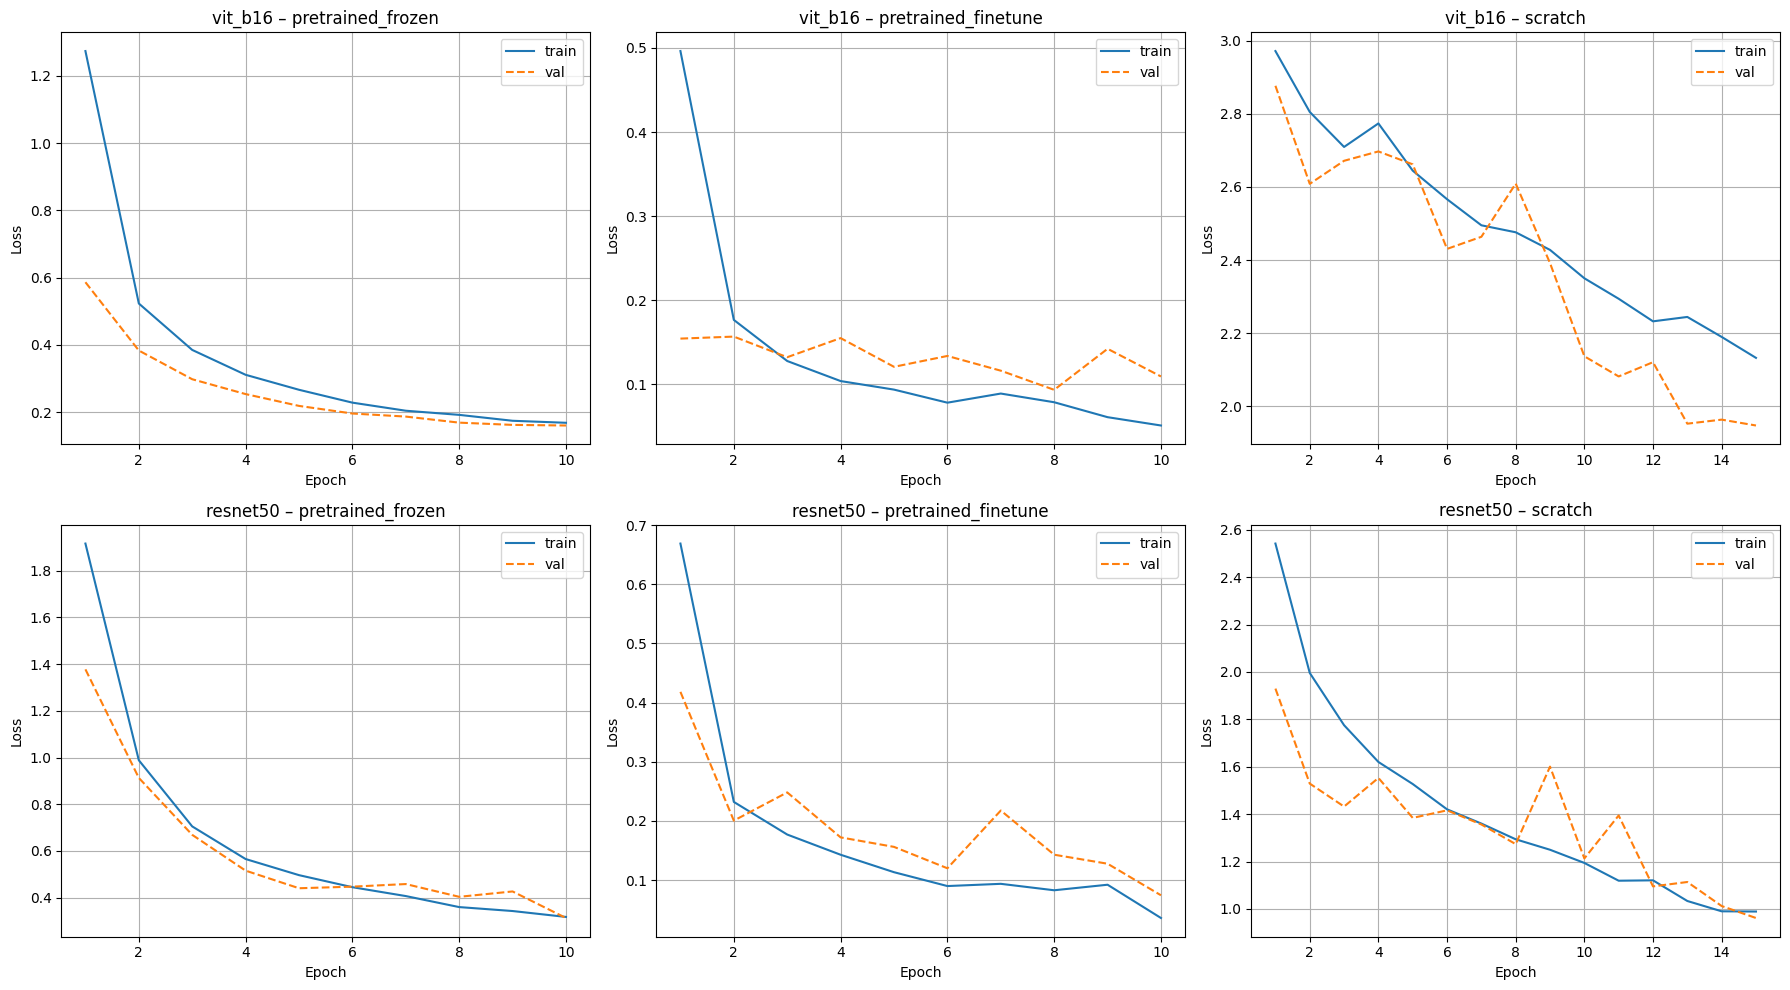

In [ ]:
def plot_loss_grid(results):
    """
    Create a grid of loss curves:
      Row 1 = ViT-B/16 (frozen, finetune, scratch)
      Row 2 = ResNet50 (frozen, finetune, scratch)
    """

    backbones = ["vit_b16", "resnet50"]
    modes = ["pretrained_frozen", "pretrained_finetune", "scratch"]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    for row_idx, backbone in enumerate(backbones):
        for col_idx, mode in enumerate(modes):
            ax = axes[row_idx, col_idx]
            history = results[backbone][mode]["history"]
            epochs = range(1, len(history["train_loss"]) + 1)

            # Plot losses
            ax.plot(epochs, history["train_loss"], label="train")
            ax.plot(epochs, history["val_loss"], linestyle="--", label="val")

            ax.set_title(f"{backbone} – {mode}")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            ax.grid(True)
            ax.legend()

    plt.tight_layout()
    plt.show()


plot_loss_grid(results)


Confusion matrices for each model

Confusion matrices for: vit_b16

Confusion matrix for: vit_b16 – pretrained_frozen


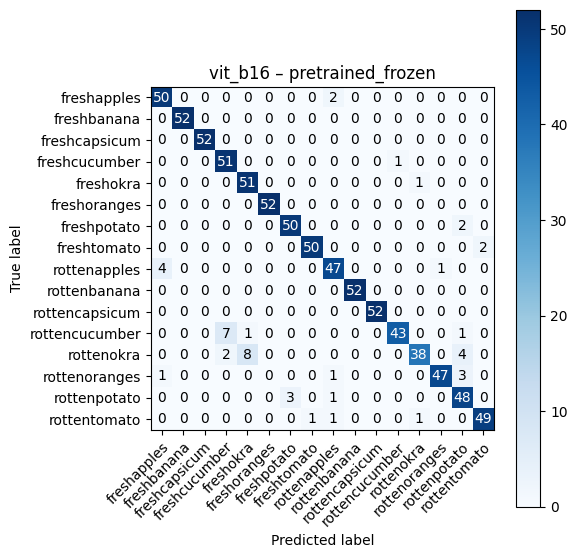


Confusion matrix for: vit_b16 – pretrained_finetune


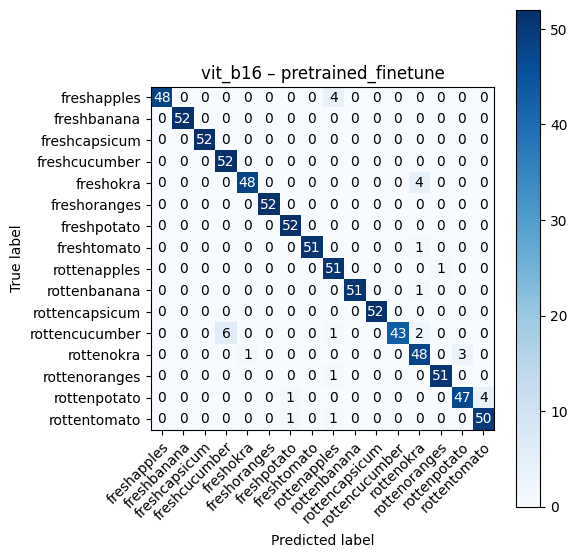


Confusion matrix for: vit_b16 – scratch


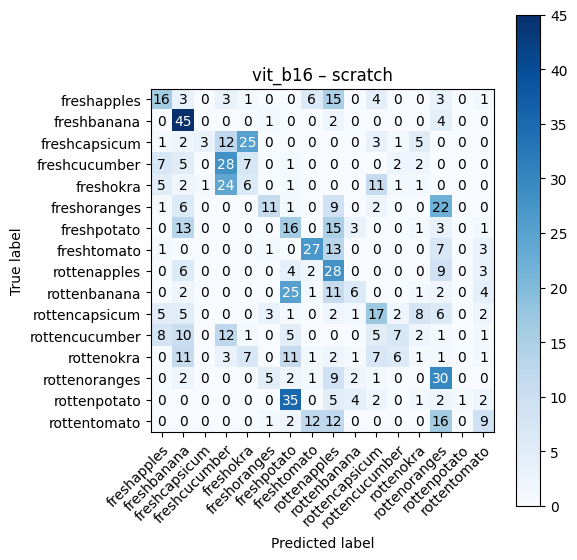

Confusion matrices for: resnet50

Confusion matrix for: resnet50 – pretrained_frozen


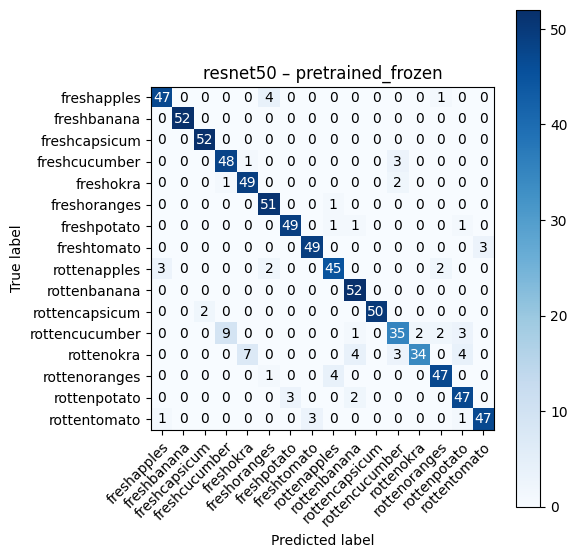


Confusion matrix for: resnet50 – pretrained_finetune


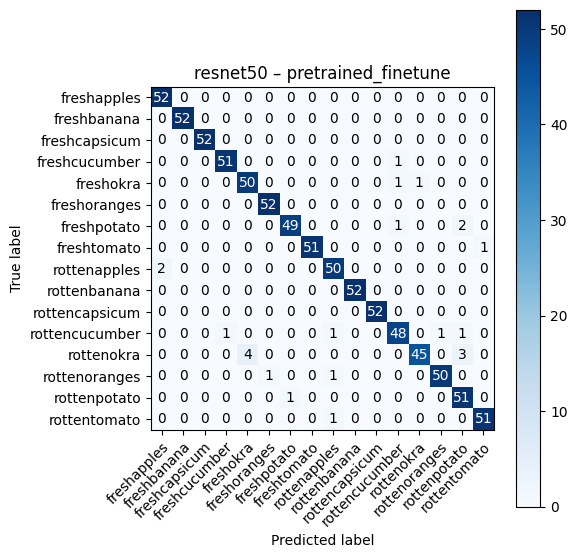


Confusion matrix for: resnet50 – scratch


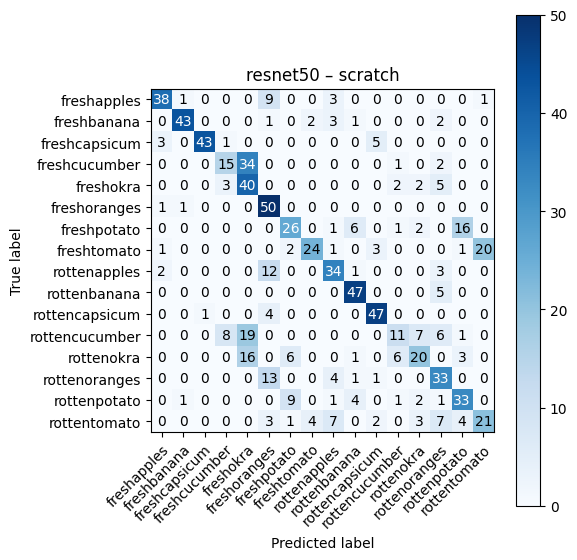

In [27]:
def plot_confusion_matrix(cm, class_names, title="Confusion matrix"):
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.figure.colorbar(im, ax=ax)

    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=class_names,
        yticklabels=class_names,
        ylabel="True label",
        xlabel="Predicted label",
        title=title,
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], "d"),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    fig.tight_layout()
    plt.show()


for backbone_name, modes in results.items():
    print(f"Confusion matrices for: {backbone_name}")

    for mode, res in modes.items():
        print(f"\nConfusion matrix for: {backbone_name} – {mode}")
        cm = res["confusion_matrix"]
        plot_confusion_matrix(
            cm,
            class_names,
            title=f"{backbone_name} – {mode}",
        )

# Saving Results from Kaggle Notebook

Saving the models and results

In [ ]:
SAVE_DIR = "/kaggle/working/models"
os.makedirs(SAVE_DIR, exist_ok=True)

print("Saving models and results to:", SAVE_DIR)
for backbone_name, modes in results.items():
    for mode, res in modes.items():
        model = res["model"]
        history = res["history"]
        cm = res["confusion_matrix"]

        model_path = os.path.join(SAVE_DIR, f"{backbone_name}_{mode}.pt")
        history_path = os.path.join(SAVE_DIR, f"{backbone_name}_{mode}_history.pkl")
        cm_path = os.path.join(SAVE_DIR, f"{backbone_name}_{mode}_confusion.pkl")

        torch.save(model.state_dict(), model_path)

        with open(history_path, "wb") as f:
            pickle.dump(history, f)

        with open(cm_path, "wb") as fa:
            pickle.dump(cm, fa)

        print(f"Saved: {backbone_name} / {mode}")

print("\nAll models saved")


Saving models and results to: /kaggle/working/models
Saved: vit_b16 / pretrained_frozen
Saved: vit_b16 / pretrained_finetune
Saved: vit_b16 / scratch
Saved: resnet50 / pretrained_frozen
Saved: resnet50 / pretrained_finetune
Saved: resnet50 / scratch

All models saved


In [ ]:
import shutil
import os

SOURCE_DIR = "/kaggle/working/models"
ZIP_PATH = "/kaggle/working/models_results.zip"

if os.path.exists(ZIP_PATH):
    os.remove(ZIP_PATH)
shutil.make_archive("/kaggle/working/models_results", "zip", SOURCE_DIR)
print("Created ZIP at:", ZIP_PATH)

Created ZIP at: /kaggle/working/models_results.zip
